<a href="https://colab.research.google.com/github/JDslay/LKA/blob/main/DCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finetuning of pretrained AlexNet (on ImageNet-Dataset) with Tobacco3482-Dataset 
Initially the AlexNet was trained with the purpose of classifying images into 1000 categories like cat and dog.
This notebook retraines the last fully connected layer of AlexNet on images of documents to categorize 10 classes (ADVE, Email, Form, Letter, Memo, News, Note, Report, Resume, Scientific)

In the import section the file for plotting the confusion matrix is imported from my Github-Repository.

In [41]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import httpimport
url = "https://raw.githubusercontent.com/JDslay/LKA/main/resources"     # from deeplizard.com respectively scikit-learn.org
with httpimport.remote_repo(["plotcm"], url):
    import plotcm                                        
import time
import progressbar

For testing purposes, data of my Google Drive have been mounted

In [42]:
from google.colab import drive
drive.mount('/content/drive')  

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Later used functions for the evaluation of the model have to be initialized

In [5]:
# All predictions in one tensor
@torch.no_grad()                                                        # gradients not needed while evaluation / saves memory if turned off
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    for batch in loader:
        images, labels = batch
        preds = model(images)
        all_preds = torch.cat((all_preds, preds), dim=0)
    return all_preds

# Number of correct predictions
def get_nbr_correct_predicted(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

# Load the training and validation datasets, prepare the data and initialize a data-loader for ease of handling data
The datastructure is essential. If training the model with 40 images of each class, a train folder with 10 subfolders each including 40 samples is crucial.
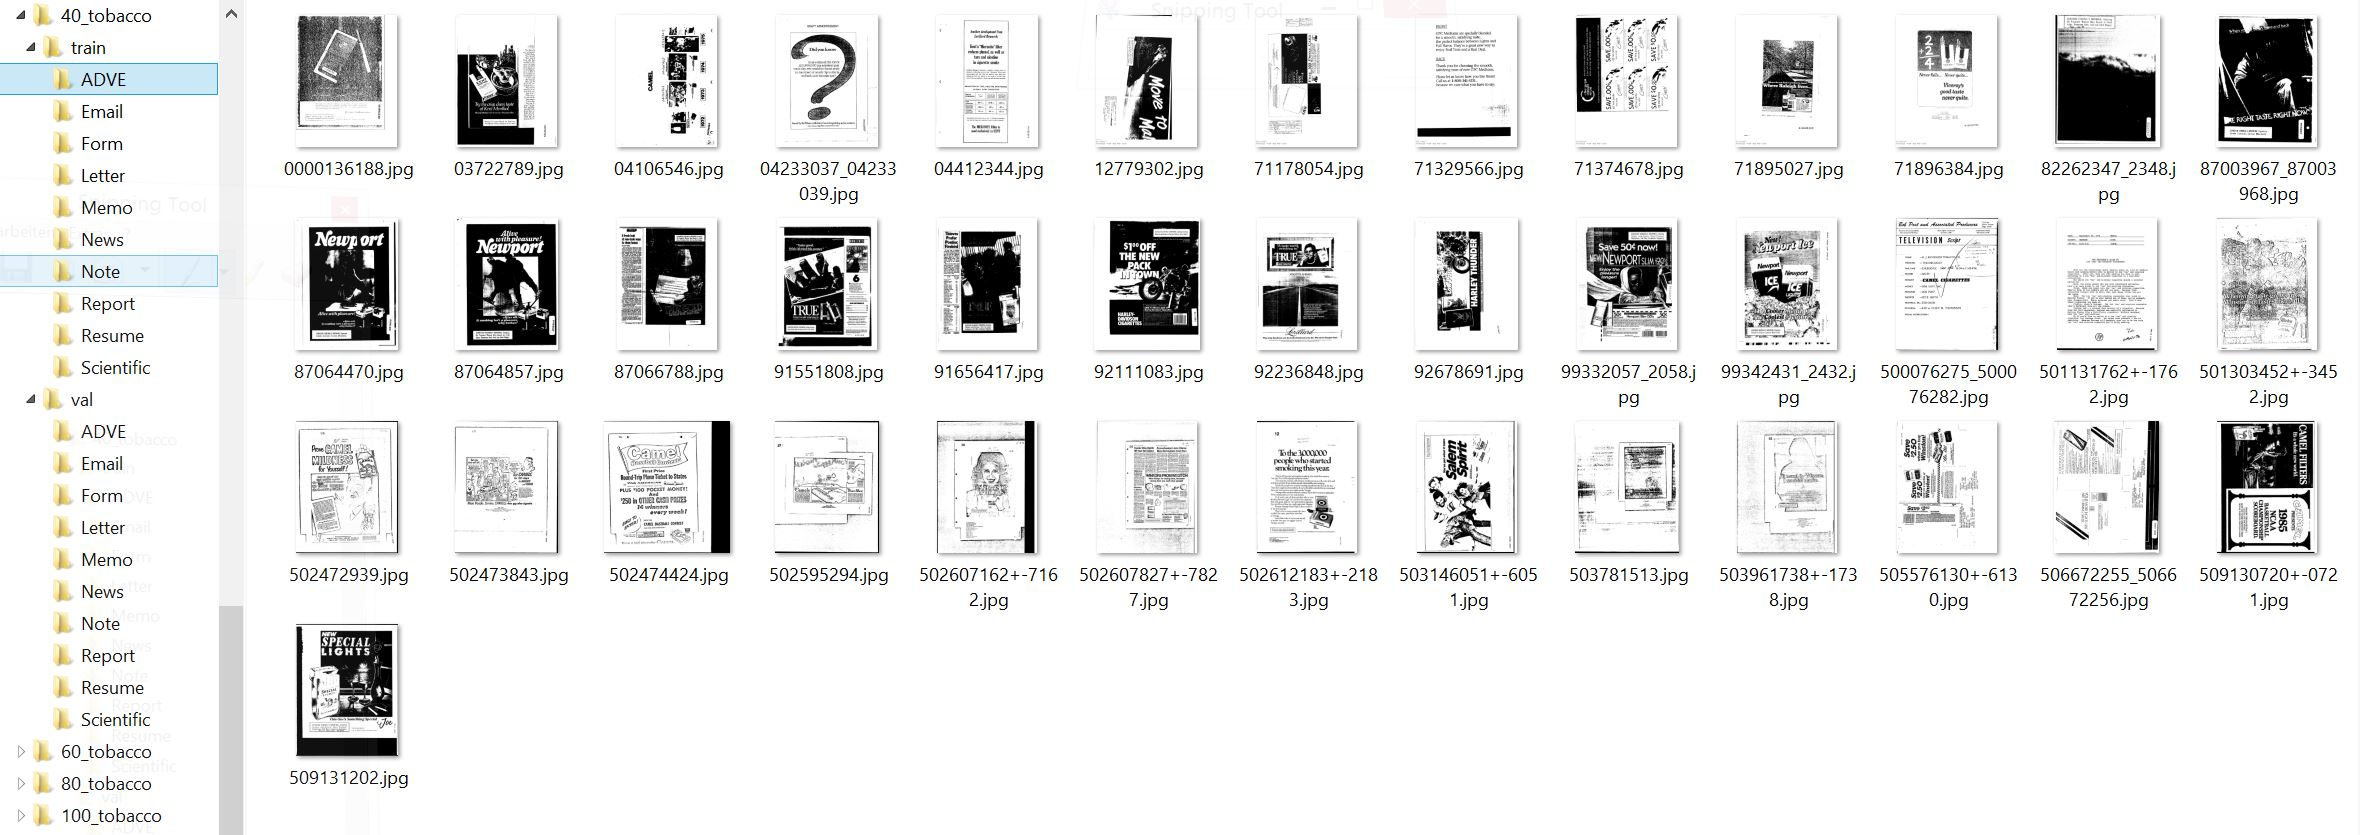

In [8]:
# load data and prepare
train_set = torchvision.datasets.ImageFolder(
    root='/content/drive/MyDrive/ColabNotebooks/data/40_tobacco/train', transform=transforms.Compose([
        transforms.Resize((227, 227)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
)
val_set = torchvision.datasets.ImageFolder(
        root='/content/drive/MyDrive/ColabNotebooks/data/40_tobacco/val', transform=transforms.Compose([
            transforms.Resize((227, 227)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    )
batchSze = 10               # also needed later in calculation of preogress bar
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batchSze, shuffle=True)  # getting shuffeled batches out of dataset
val_loader = torch.utils.data.DataLoader(val_set, batch_size=100)                   # no shuffling needed for evaluation

# Get the pretrained AlexNet model and retrain the last fully connected layer

In [6]:
# load pretrained alexnet and prepare for finetuning
alexNetMod = models.alexnet(pretrained=True)

# freeze parameters
for param in alexNetMod.parameters():
    param.requires_grad = False

# change last fully connected layer with new and 10 outputs
alexNetMod.classifier[6] = nn.Linear(4096, 10)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


# Retrain the last layer of the modified AlexNet

In [47]:
# TRAIN MODEL
optimizer = optim.SGD(alexNetMod.parameters(), lr=0.0001,momentum=0.9, weight_decay=0.0005)

epochs = 3
bar = progressbar.ProgressBar(max_value=len(train_set)/batchSze*epochs)
i = 0
# training loop
for epoch in range(epochs):
    total_loss = 0
    total_correct = 0
    for batch in train_loader:                  # Get Batch
        images, labels = batch                  # unpack batch
        preds = alexNetMod(images)              # pass Batch
        loss = F.cross_entropy(preds, labels)   # calculate Loss
        optimizer.zero_grad()                   # set gradients to zero  
        loss.backward()                         # calculate gradients
        optimizer.step()                        # Updating weights
        
        # show progress of training visually and numercally  
        i+=1
        bar.update(i)
        total_loss += loss.item()                
        total_correct += get_nbr_correct_predicted(preds, labels)   
    print('   epoch:', epoch, 'total_correct:',total_correct, "loss:", total_loss)

# show results of training
correct_train_perc = 100*total_correct/len(train_set)
print('percentage of correct predictions within training', correct_train_perc)

 33% (40 of 120.0) |#######              | Elapsed Time: 0:00:36 ETA:   0:01:24

   epoch: 0 total_correct: 274 loss: 40.48336660861969


 66% (80 of 120.0) |##############       | Elapsed Time: 0:01:14 ETA:   0:00:39

   epoch: 1 total_correct: 269 loss: 38.953471660614014


100% (120 of 120.0) |####################| Elapsed Time: 0:01:52 ETA:  00:00:00

   epoch: 2 total_correct: 267 loss: 38.533934742212296
percentage of correct predictions within training 66.75


# Evaluate the retrained Model

In [48]:
# Predict all images
val_preds = get_all_preds(alexNetMod, val_loader)

In [49]:
# print number of correct predictions and accuracy 
labeltensor = torch.tensor(val_set.targets)
preds_correct = get_nbr_correct_predicted(val_preds, labeltensor)
print('total correct:', preds_correct, 'out of ', len(val_set), 'documents')
print('accuracy: ', 100*preds_correct / len(val_set), '%')

total correct: 1461 out of  3082 documents
accuracy:  47.40428293316029 %


Normalized confusion matrix
[[0.86842105 0.01052632 0.02631579 0.03684211 0.00526316 0.03684211
  0.00526316 0.00526316 0.00526316 0.        ]
 [0.         0.85867621 0.02146691 0.01431127 0.00357782 0.00357782
  0.05366726 0.03935599 0.00178891 0.00357782]
 [0.00255754 0.08439898 0.72634271 0.07672634 0.03580563 0.00767263
  0.01023018 0.01790281 0.03836317 0.        ]
 [0.         0.12713472 0.0512334  0.37381404 0.10056926 0.0227704
  0.         0.29411765 0.0227704  0.00759013]
 [0.00517241 0.17241379 0.1862069  0.27758621 0.12068966 0.01551724
  0.00862069 0.19137931 0.0137931  0.00862069]
 [0.08108108 0.05405405 0.03378378 0.03378378 0.         0.64189189
  0.         0.04054054 0.         0.11486486]
 [0.01863354 0.16149068 0.19875776 0.10559006 0.13043478 0.02484472
  0.32298137 0.0310559  0.00621118 0.        ]
 [0.         0.08444444 0.08       0.14222222 0.04444444 0.05777778
  0.00444444 0.51555556 0.02222222 0.04888889]
 [0.         0.075      0.175      0.0125     0.0375 

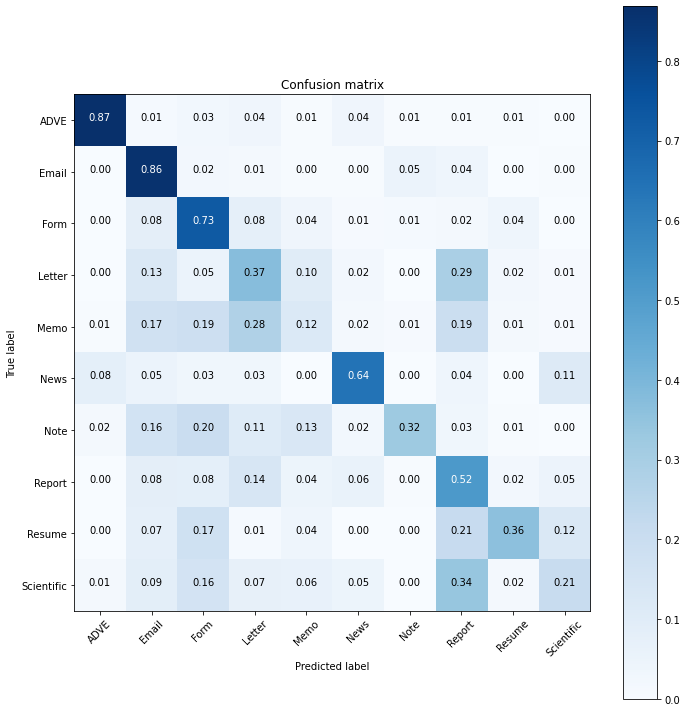

In [50]:
# Show confusion matrix
cm = confusion_matrix(labeltensor, train_preds.argmax(dim=1))
names = ('ADVE', 'Email', 'Form', 'Letter', 'Memo',
         'News', 'Note', 'Report', 'Resume', 'Scientific')
plt.figure(figsize=(10, 10))
plotcm.plot_confusion_matrix(cm, names, normalize=True)